<a href="https://colab.research.google.com/github/ahhCrap/Deepfake_Review_Detection/blob/master/attnVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Auto Encoder

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

## Imports

In [0]:
import torch as t
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F

from torch.nn.modules.loss import NLLLoss
from torch.nn.utils.rnn import pad_sequence

In [0]:
from scipy.stats import moment, skew

import numpy as np
import pandas as pd
import scipy.special as sps
import matplotlib.pyplot as plt

In [0]:
import math
import json
import spacy
import pickle

from tqdm import tqdm
from collections import defaultdict

In [0]:
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, \
                            average_precision_score, \
                            recall_score, \
                            f1_score

In [0]:
import nltk
import nltk.translate.bleu_score as bleu
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Configuration

In [0]:
device = t.device("cuda:0" if (t.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
VOCAB_SIZE = 1024
BATCH_SIZE = 256

Q_DIM = K_DIM = V_DIM = 32
CODE_DIM = 64
HID_DIM = 512
EMB_DIM = 64

MAX_LEN = 14
MAX_SEQ = MAX_LEN + 2 # Since we're going to have SOS as start and EOS as end

OPT = opt.Adam 
HEADS = 3
LR = 1e-4

INCREASE = 4
DECREASE = 4

## Utils

### Save

In [0]:
def load(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [0]:
def save(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file,outfile)
    outfile.close()

In [0]:
def record_checkpoint(e, vae, nll_losses, kld_losses, VERSION):
    t.save({
        'epoch': e,
        'model_state_dict': vae.state_dict(),
        'optimizer_state_dict': vae.opt.state_dict(),
        'nll_losses': nll_losses,
        'kld_losses': kld_losses
        }, model_path + str(VERSION) + '_checkpoint_' + str(e))

### Text

In [0]:
# Lowering, tokenizing 'sentences'
def tokenize(sentences):
    return [word_tokenize(sent.lower()) for sent in sentences]

In [0]:
def tokenize_online(file_path):
    tokenized_sentences = []
    with open(file_path, 'r') as f:
        for line in f:
            tokenized_sentences += [word_tokenize(line.lower())]
    return tokenized_sentences

In [0]:
def ids_from_sent(sent):
    return [vocab.word2index[tok] for tok in sent]

In [0]:
def tens_from_text(text):
    return [t.tensor([SOS] + ids_from_sent(s) + [EOS], device=device) for s in text]

In [0]:
tok2read = {'PAD': ' ', 'UNK': 'unk', 'SOS': '>>', 'EOS': '<<'}

In [0]:
def raw2readable(sentence):
    for i, w in enumerate(sentence):
        if w in tok2read:
            sentence[i] = tok2read[w]
    return sentence

In [0]:
tok2adv = {'PAD': '', 'UNK': 'unk', 'SOS': '', 'EOS': ''}

In [0]:
def raw2adversarial(sentence):
    for i, w in enumerate(sentence):
        if w in tok2adv:
            sentence[i] = tok2adv[w]
    return sentence

In [0]:
def compute_size(dataset):
    dataset_size = 0
    with open(dataset, 'r') as f:
        for line in f:
            dataset_size += 1
    return dataset_size

In [0]:
def prep_sentences(sentences):
    assert isinstance(sentences[0], list), "'sentences' is not list of list"
    return [['SOS']+sent+['EOS']+['PAD']*(MAX_SEQ-len(sent)-2) for sent in sentences]

### Math

In [0]:
def gelu(x):
    return 0.5 * x * (1 + t.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * t.pow(x, 3))))

In [0]:
def cal_angle(position, hid_idx, emb_dim):
    return position / np.power(10000, 2 * (hid_idx // 2) / emb_dim)

def get_posi_angle_vec(position, emb_dim):
    return [cal_angle(position, hid_j, emb_dim) for hid_j in range(emb_dim)]

def sinusoid_encoding_table(n_position, emb_dim=EMB_DIM):
    sinusoid_table = np.array(
        [get_posi_angle_vec(pos_i, emb_dim) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return t.tensor(sinusoid_table, dtype=t.float, device=device)

In [0]:
def pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k, device=device)  # batch_size x len_q x len_k

In [0]:
def seq_mask(batch_size, seq_len):
    attn_shape = [batch_size, seq_len, seq_len]
    subsequent_mask = t.triu(
        t.ones(attn_shape, dtype=t.bool, device=device), diagonal=1)
    return subsequent_mask # subsequent_mask: [batch_size, seq, seq]

In [0]:
def pad_like(tensor, t_like):
    old_shape = tensor.shape
    new_shape = t_like.shape
    assert len(old_shape) == len(new_shape)
    
    diffs = []
    for i in range(len(old_shape)):
        diffs += [new_shape[i] - old_shape[i]]
    pads = []
    for d in diffs:
        half = d//2
        rest = d - half
        pads.extend([half, rest])
    
    return F.pad(tensor, pads[::-1], mode='constant', value=PAD)

In [0]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
def truncated_permutation(n, max_n):
    assert n < max_n

    perm = set()
    while len(perm) < n:
        random_samples = np.random.randint(low=0, high=max_n-1, size=(n-len(perm)))
        perm.update(random_samples.tolist())
    return list(perm)

### Neural Nets

In [0]:
class RNN(nn.Module):
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim,
               n_layers, bidirectional, dropout, pad_idx):
    super(RNN, self).__init__()
    self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
    self.rnn = nn.LSTM(embedding_dim, 
                       hidden_dim, 
                       num_layers=n_layers, 
                       bidirectional=bidirectional, 
                       dropout=dropout)
    self.linear = nn.Linear(2*hidden_dim, output_dim)
    self.dropout = nn.Dropout(dropout)
      
  def forward(self, x, text_lengths):
    embedded = self.dropout(self.embedding(x))
    
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)    
    packed_output, (hidden, cell) = self.rnn(packed_embedded)
    
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    hidden = self.dropout(t.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

    return self.linear(hidden)
    
  def train(self, iterator):
    
    for batch in iterator:
      text, text_lengths = batch.text
      self.opt.zero_grad()
      
      prediction = self.forward(text, text_lengths).squeeze(1)
      self.loss(prediction, batch.label).backward()
      self.opt.step()
      
  def compile(self):
    self.opt = optim.Adam(self.parameters())
    self.loss = nn.BCEWithLogitsLoss()
  
  def evaluate(self, iterator):
    epoch_loss = 0
    epoch_acc = 0
        
    with t.no_grad():
    
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = self.forward(text, text_lengths).squeeze(1)
            
            loss = self.loss(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [0]:
def predict_sentiment(model, sentence): 
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [s2i[t] for t in tokenized]
    length = [len(indexed)]
    tensor = t.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = t.LongTensor(length)
    prediction = t.sigmoid(model(tensor, length_tensor))
    return prediction.item()

## Dataset

### Vocabulary

In [0]:
PAD = 0
UNK = 1
SOS = 2
EOS = 3

class Vocab:
    def __init__(self):
        self.word2count = {}
        self.word2index = {'PAD': PAD, 'UNK': UNK, "SOS": SOS, "EOS": EOS}
        self.index2word = {PAD: 'PAD', UNK: 'UNK', SOS: "SOS", EOS: "EOS"}
        self.n_words = 4 
        
    def add_text(self, text):
        for sent in tqdm(text): # assuming the text is a list of sentences
            for tok in sent:
                self.add_word(tok)

    def add_word(self, word):
        try:
            self.word2count[word] += 1
        except KeyError:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1

    def trim(self, n_tokens):
        n_tokens -= 4 # Since we have 4 special characters
        
        words = list(self.word2count.keys())
        counts = list(self.word2count.values())
        counts, words = zip(*sorted(zip(counts, words))) # order the words by their usage
        
        # ============= Re-create 'word2index' and 'word2count' ================
        temp_word2index = {'PAD': PAD, 'UNK': UNK, "SOS": SOS, "EOS": EOS}
        temp_word2count = {PAD: 'PAD', UNK: 'UNK', SOS: "SOS", EOS: "EOS"}
        temp_n_words = 4         
        
        for w in list(words)[-n_tokens:]:
            temp_word2index[w] = temp_n_words
            temp_word2count[w] = self.word2count[w]
            temp_n_words += 1
            
        self.word2index = defaultdict(lambda: UNK, temp_word2index)
        self.word2count = defaultdict(lambda: 0, temp_word2count)
        self.n_words = temp_n_words
            
        # ====================== Re-create 'index2word' ========================
        self.index2word = {}    
        for w, i in self.word2index.items():
            self.index2word[i] = w

### Batcher

In [0]:
# creates the batches and pads sequences
class Batcher:
    def __init__(self, pad=PAD):
        self.pad = pad

    def get_batches(self, tensors, batch_size):
        n = len(tensors)
        drop = n % batch_size

        dropped = tensors[-drop:] if drop != 0 else []

        batches = []
        for i in range(n // batch_size - 1):
           batches.append(tensors[i * batch_size:(i + 1) * batch_size]) 
        
        return batches, dropped
    
    def pad_batches(self, batches, batch_first=True):
        swap = (1, 0) if batch_first else (0, 1)
        return [pad_sequence(batch, padding_value=self.pad).permute(swap).to(device) for batch in batches]

    def insta_batch(self, sents, vocab):
        assert isinstance(sents[0], list), "'sents' is not list of list"
        temp_sents = sents + [['dummy'] * MAX_LEN]
        tens = tens_from_text(temp_sents)
        return pad_sequence(tens, padding_value=self.pad)[:, :-1].permute(1, 0).to(device)

## Architecture

### Attention

In [0]:
MASK = float('-inf')

In [0]:
class ScaledAttn(nn.Module):
    def __init__(self):
        super(ScaledAttn, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        batch_size, n_heads, seq_len, dim = Q.shape

        scores = t.matmul(Q, K.transpose(-1, -2)) / np.sqrt(dim) # scores: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, MASK) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = t.matmul(attn, V)
        return context, attn

In [0]:
# Modified for self-attention only
class MHA(nn.Module):
    def __init__(self, emb_dim=EMB_DIM, dim=Q_DIM, n_heads=HEADS):
        super(MHA, self).__init__()
        
        self.dim = dim # dimension of querys, keys and values
        self.emb_dim = emb_dim
        self.n_heads = n_heads
        
        self.W_Q = nn.Linear(emb_dim, n_heads * dim) 
        self.W_K = nn.Linear(emb_dim, n_heads * dim) 
        self.W_V = nn.Linear(emb_dim, n_heads * dim) 
        
        self.projection = nn.Linear(n_heads * dim, emb_dim)
        self.lay_norm = nn.LayerNorm(emb_dim)

    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x seq_len x dim], k: [batch_size x seq_len x dim], v: [batch_size x seq_len x dim]
        residual = Q
        batch_size, seq_len, emb_dim = Q.shape

        # (B, S, E) -proj-> (B, S, H x D) -split-> (B, S, H, D) -trans-> (B, H, S, D)
        q_s = self.W_Q(Q).view(batch_size, seq_len, self.n_heads, self.dim).transpose(1, 2)  # q_s: [batch_size x n_heads x seq_len x dim]
        k_s = self.W_K(K).view(batch_size, seq_len, self.n_heads, self.dim).transpose(1, 2)  # k_s: [batch_size x n_heads x seq_len x dim]
        v_s = self.W_V(V).view(batch_size, seq_len, self.n_heads, self.dim).transpose(1, 2)  # v_s: [batch_size x n_heads x seq_len x dim]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # attn_mask : [batch_size x n_heads x seq_len x seq_len]

        # context: [batch_size x n_heads x seq_len x dim], attn: [batch_size x n_heads x seq_len x seq_len]
        context, attn = ScaledAttn()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.n_heads * self.dim) # context: [batch_size x seq_len x n_heads * dim]
        output = self.projection(context)
        return self.lay_norm(output + residual), attn # output: [batch_size x seq_len x emb_dim]

### Encoder

In [0]:
class Reshaper1d(nn.Module):
    def __init__(self, seq_len, plus):
        super(Reshaper1d, self).__init__()
        self.conv1d = nn.Conv1d(seq_len, seq_len + plus, kernel_size=1)
    
    def forward(self, inputs):
        return self.conv1d(inputs)

In [0]:
class DownSampFF(nn.Module):
    def __init__(self, emb_dim=EMB_DIM, hid_dim=HID_DIM, dec=DECREASE):
        super(DownSampFF, self).__init__()
        self.conv1 = nn.Conv1d(emb_dim, hid_dim, kernel_size=1)
        self.conv2 = nn.Conv1d(hid_dim, emb_dim, kernel_size=1)
        self.lay_norm = nn.LayerNorm(emb_dim)

    def forward(self, inputs):
        output = self.conv1(inputs.transpose(1, 2))
        output = t.relu(output)
        output = self.conv2(output).transpose(1, 2)
        output = self.lay_norm(output)
        return t.relu(output)

In [0]:
class EnCore(nn.Module):
    def __init__(self, emb_dim=EMB_DIM, hid_dim=HID_DIM, dec=DECREASE):
        super(EnCore, self).__init__()
        self.n_lay = MAX_SEQ // dec - 1

        self.positioner = nn.Embedding.from_pretrained(
            sinusoid_encoding_table(MAX_SEQ + 1, emb_dim), freeze=True)

        self.attns = nn.ModuleList([MHA(emb_dim, hid_dim)] * (self.n_lay + 1))
        self.downs = nn.ModuleList([DownSampFF(emb_dim, hid_dim, dec)] * self.n_lay)
        self.res1ds = nn.ModuleList([Reshaper1d(MAX_SEQ-dec*i, -dec) for i in range(self.n_lay)]) 

    def forward(self, x):
        intra_attns = []
        for i in range(self.n_lay): # x: [batch_size, seq_len, emb_dim]
            batch_size, seq_len, emb_dim = x.shape
            x += self.positioner(t.tensor(
                [[seq_len]+[*range(1, seq_len)]] * batch_size, 
                dtype=t.long, device=device))

            mask = seq_mask(batch_size, seq_len) 
            x, attn = self.attns[i](x, x, x, mask)
            x = self.downs[i](x) + x      
            x = self.res1ds[i](x)           
              
            intra_attns += [attn]
        
        batch_size, seq_len, emb_dim = x.shape
        mask = seq_mask(batch_size, seq_len) 
        x, attn = self.attns[-1](x, x, x, mask)

        return x, intra_attns + [attn]

In [0]:
class Encoder(nn.Module):
     def __init__(self, emb_dim=EMB_DIM, hid_dim=HID_DIM, code_dim=CODE_DIM, dec=DECREASE, vocab_size=VOCAB_SIZE):
        super(Encoder, self).__init__()
        self.emb_dim = emb_dim
        self.dec = dec

        self.embedder = nn.Embedding(vocab_size, emb_dim)
        self.core = EnCore(emb_dim, hid_dim, dec)

        self.dense_mu = nn.Linear(dec * emb_dim, code_dim)
        self.dense_var = nn.Linear(dec * emb_dim, code_dim)

        self.norm_mu = nn.LayerNorm(code_dim)
        self.norm_var = nn.LayerNorm(code_dim)


     def forward(self, x):
        batch_size, seq_len = x.shape

        embed = self.embedder(x)
                
        context, intra_attns = self.core(embed)
        context = context.reshape(batch_size, self.dec * self.emb_dim)
        
        mu = self.dense_mu(context)
        logvar = self.dense_var(context)

        return self.norm_mu(mu), self.norm_var(logvar), intra_attns

### Decoder

In [0]:
class UpSampFF(nn.Module):
    def __init__(self, emb_dim=EMB_DIM, hid_dim=HID_DIM, inc=INCREASE):
        super(UpSampFF, self).__init__()
        self.conv1 = nn.ConvTranspose1d(emb_dim, hid_dim, kernel_size=1)
        self.conv2 = nn.ConvTranspose1d(hid_dim, emb_dim, kernel_size=1)
        self.lay_norm = nn.LayerNorm(emb_dim)

    def forward(self, inputs): # inputs: [batch_size, seq_len, emb_dim]
        output = self.conv1(inputs.transpose(1, 2))
        output = t.relu(output)
        output = self.conv2(output).transpose(1, 2)
        output = self.lay_norm(output)
        return t.relu(output)

In [0]:
class DeCore(nn.Module):
    def __init__(self, emb_dim=EMB_DIM, hid_dim=HID_DIM, inc=INCREASE):
        super(DeCore, self).__init__()
        self.n_lay = MAX_SEQ // inc - 1

        self.positioner = nn.Embedding.from_pretrained(
            sinusoid_encoding_table(MAX_SEQ + 1, emb_dim), freeze=True)

        self.attns = nn.ModuleList([MHA(emb_dim, hid_dim)] * (self.n_lay + 1))
        self.ups = nn.ModuleList([UpSampFF(emb_dim, hid_dim, inc)] * self.n_lay)
        self.res1ds = nn.ModuleList([Reshaper1d(inc+inc*i, inc) for i in range(self.n_lay)]) 


    def forward(self, x):
        intra_attns = []
        for i in range(self.n_lay): # x: [batch_size, seq_len, emb_dim]
            batch_size, seq_len, emb_dim = x.shape
            x += self.positioner(t.tensor(
                [[seq_len]+[*range(1, seq_len)]] * batch_size, 
                dtype=t.long, device=device))

            mask = seq_mask(batch_size, seq_len) 
            x, attn = self.attns[i](x, x, x, mask)
            x = self.ups[i](x) + x  
            x = self.res1ds[i](x)                 

            intra_attns += [attn]
        
        batch_size, seq_len, emb_dim = x.shape
        mask = seq_mask(batch_size, seq_len) 
        x, attn = self.attns[-1](x, x, x, mask)
        
        return x, intra_attns+[attn]
    

In [0]:
class Decoder(nn.Module):
     def __init__(self, emb_dim=EMB_DIM, hid_dim=HID_DIM, code_dim=CODE_DIM, inc=INCREASE, vocab_size=VOCAB_SIZE):
        super(Decoder, self).__init__()
        self.emb_dim = emb_dim 
        self.inc = inc 

        self.dense = nn.Linear(code_dim, inc * emb_dim)
        self.core = DeCore(emb_dim, hid_dim, inc)
        self.dembedder = nn.Linear(emb_dim, vocab_size, bias=False)

     def forward(self, x):
        batch_size, hid_dim = x.shape
        embed = self.dense(x).view(batch_size, self.inc, self.emb_dim)
                
        embed, intra_attns = self.core(embed)
        
        logits = self.dembedder(embed)
        probs = F.log_softmax(logits, dim=-1)

        return probs, intra_attns

### VAE

In [0]:
class VAE(nn.Module):
    def __init__(self, emb_dim=EMB_DIM, hid_dim=HID_DIM, code_dim=CODE_DIM, opt=OPT):
        super(VAE, self).__init__()
        
        self.encoder = Encoder(emb_dim, hid_dim, code_dim)
        self.decoder = Decoder(emb_dim, hid_dim, code_dim)

        # self.encoder.embedder.weight = self.decoder.dembedder.weight
        self.opt = opt(self.parameters(), LR, betas=[0.9, 0.999])
    
    def distribute(self, mu, logvar):
        std = t.exp(0.5 * logvar)
        eps = t.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar, dec_self_attns = self.encoder(x)
        codes = self.distribute(mu, logvar)       
        probs, enc_self_attns = self.decoder(codes)
        
        return (mu, logvar), probs, (dec_self_attns, enc_self_attns)

## Optimization

In [0]:
def train_iter(tar_batch, vae, alpha):
    vae.train()
    vae.opt.zero_grad()
    batch_size, seq_len = tar_batch.shape

    (mu, logvar), probs, _ = vae(tar_batch)
    
    # Reconstruction Error
    nll_loss = NLLLoss(reduction='mean')(
        probs.reshape(batch_size * seq_len, VOCAB_SIZE), 
        tar_batch.reshape(batch_size * seq_len))
    
    # Regularization Error
    kld_loss = (-0.5 * t.mean(1 + logvar - mu.pow(2) - logvar.exp()))
    
    loss = nll_loss + kld_loss * alpha
    loss.backward()
    vae.opt.step()

    return nll_loss.item(), kld_loss.item()

### Epoch

In [0]:
def online_epoch(file_path, vae, alpha, batcher, vocab, batch_size=BATCH_SIZE):
    d_size = compute_size(file_path)
    nll_batch_losses = []
    kld_batch_losses = []
    with open(file_path, 'r') as f:
        i = 1
        tar_batch = []
        processed_batches = 0
        for line in f:
            tar_batch += [word_tokenize(json.loads(line)['review'].lower())]

            if len(tar_batch) % batch_size == 0:
                tar_batch = batcher.insta_batch(tar_batch, vocab)
                nll_batch_loss, kld_batch_loss = train_iter(tar_batch, vae, alpha)
        
                nll_batch_losses += [nll_batch_loss]
                kld_batch_losses += [kld_batch_loss]       

                tar_batch = []
                processed_batches += 1
                
            # ----------------------- UPDATING PROGRESS ------------------------
            if processed_batches > i * ((d_size / batch_size) // 10):
                print('.', sep='', end='') 
                i += 1
            # ------------------------------------------------------------------    
    print(' |', sep=' ', end=' ')
    
    return sum(nll_batch_losses) / processed_batches, sum(kld_batch_losses) / processed_batches

### Training

In [0]:
def online_train(file_path, vae, epochs, batcher, vocab, batch_size=BATCH_SIZE):
    nll_losses = []
    kld_losses = []
    for i in range(e, epochs+e):
        print('Epoch:', '{:3d}'.format(i), '|', sep=' ', end=' ')
        
        alpha = ALPHA
        nll_loss, kld_loss = online_epoch(file_path, vae, alpha, batcher, vocab, batch_size)
        nll_losses += [nll_loss]
        kld_losses += [kld_loss]
            
        print('NLL:', '{:7.6f}'.format(nll_loss), '|', 
              'KLD:', '{:7.6f}'.format(kld_loss), '|',
              'alpha:', alpha)
    
    return nll_losses, kld_losses, epochs+e

## Evaluation

In [0]:
def gather_random_sentences(file_path, n=1024):
    d_size = compute_size(file_path)    
    random_samples = truncated_permutation(n, d_size-1)
    
    sentences = []
    with open(file_path, 'r') as f:
        i = 0
        for line in f:
            if i in random_samples:
                sentences += [word_tokenize(json.loads(line)['review'].lower())]
                if len(sentences) == n:
                    break
            i += 1
    return sentences

### Performance Evaluation

In [0]:
def performance_evaluation(file_path, vae, batch_size=64):
    vae.eval()

    with open(file_path, 'r') as f:
        nll_batch_losses = []
        kld_batch_losses = []
        pp_batch_losses = []

        tar_batch = []
        for line in f:
            tar_batch += [word_tokenize(json.loads(line)['review'].lower())]

            if len(tar_batch) % batch_size == 0:
                tar_batch = batcher.insta_batch(tar_batch, vocab)
               
                # ------------------------ ITERATION ---------------------------
                batch_size, seq_len = tar_batch.shape 

                (mu, logvar), probs, _ = vae(tar_batch)
        
                # Reconstruction Error
                nll_loss = NLLLoss(reduction='mean')(
                    probs.reshape(batch_size * seq_len, VOCAB_SIZE), 
                    tar_batch.reshape(batch_size * seq_len))
                
                pp_loss = t.exp(nll_loss)
                
                # Regularization Error
                kld_loss = (-0.5 * t.mean(1 + logvar - mu.pow(2) - logvar.exp()))
                # --------------------------------------------------------------  
                nll_batch_losses += [nll_loss.item()]
                pp_batch_losses += [pp_loss.item()]
                kld_batch_losses += [kld_loss.item()]

                tar_batch = []

    return sum(nll_batch_losses)/len(nll_batch_losses), \
           sum(pp_batch_losses)/len(pp_batch_losses), \
           sum(kld_batch_losses)/len(kld_batch_losses), 

In [0]:
def blue_evaluation(file_path, vae, batch_size, n_gram=4):
    vae.eval()

    sentences = gather_random_sentences(file_path, batch_size)
    batch = batcher.insta_batch(sentences, vocab)
    batch_size, seq_len = batch.shape

    _, probs, _ = vae(batch)

    word_ids = probs.max(dim=-1, keepdim=False)[1] 
    predictions = sentences_from_tensors(word_ids, vocab, at=-1)

    sentences = prep_sentences(sentences)
    return bleu_scoring(sentences, predictions, n_gram)

In [0]:
def bleu_evaluation(file_path, vae, batch_size=64, n_gram=4):
    vae.eval()

    with open(file_path, 'r') as f:
        bleus = []

        tar_batch = []
        sentences = []
        for line in f:
            sent = word_tokenize(json.loads(line)['review'].lower())
            tar_batch += [sent]
            sentences += [sent]

            if len(tar_batch) % batch_size == 0:
                tar_batch = batcher.insta_batch(tar_batch, vocab)

                batch_size, seq_len = tar_batch.shape

                _, probs, _ = vae(tar_batch)

                word_ids = probs.max(dim=-1, keepdim=False)[1] 
                predictions = sentences_from_tensors(word_ids, vocab, at=-1)

                sentences = prep_sentences(sentences)
                bleus += [bleu_scoring(sentences, predictions, n_gram)]

                tar_batch = []
                sentences = []

        return sum(bleus)/len(bleus)

In [0]:
def bleu_scoring(targets, predictions, n_gram=4):
    smoothing = bleu.SmoothingFunction().method7
    wights = [1 / n_gram] * n_gram
    references = [[target] for target in targets]
    
    return bleu.corpus_bleu(references, predictions,
                            weights=wights,
                            smoothing_function=smoothing)

### Sentence Evaluation

In [0]:
def random_evaluation(vae, batch_size, scaler=1):
    vae.eval()
    noise_batch = t.rand(batch_size, CODE_DIM, device=device) * scaler
    probs, attns = vae.decoder(noise_batch)
    
    word_ids = probs.max(dim=-1, keepdim=False)[1] # [batch_size, seq_len]
    return sentences_from_tensors(word_ids, vocab, at=batch_size)

In [0]:
def interpolation_evaluation(vae, file_path, n=10):
    vae.eval()
    sentence_0, sentence_1, interps = interpolate(vae, file_path, n)
    
    interps = t.cat(interps, dim=0)
    probs, attns = vae.decoder(interps)
    
    word_ids = probs.max(dim=-1, keepdim=False)[1] # [batch_size, seq_len]
    return sentence_0, sentence_1, sentences_from_tensors(word_ids, vocab, at=n)

In [0]:
def interpolate(vae, file_path, n=10):
    d_size = compute_size(file_path)
    random_samples = np.random.randint(low=0, high=d_size-1, size=(2)).tolist()
    
    sentences = []
    with open(file_path, 'r') as f:
        i = 0
        for line in f:
            if i in random_samples:
                sentences += [word_tokenize(json.loads(line)['review'].lower())]
                if len(sentences) == 2:
                    break
            i += 1

    sent_batch = batcher.insta_batch(sentences, vocab)
    sentence_0 = sent_batch[0].unsqueeze(0)
    sentence_1 = sent_batch[1].unsqueeze(0)

    mu_0, logvar_0, _ = vae.encoder(sentence_0)
    mu_1, logvar_1, _ = vae.encoder(sentence_1)

    encoded_0 = vae.distribute(mu_0, logvar_0)
    encoded_1 = vae.distribute(mu_1, logvar_1)

    interpolation = [encoded_0*(1-i) + encoded_1*i for i in np.linspace(0, 1, num=n)]

    return sentence_0, sentence_1, interpolation

In [0]:
def sentences_from_tensors(tensors, vocab, at=2):
    sentences = []
    for i in range(tensors.size(0)):
        sentences += [[vocab.index2word[n.item()] for n in tensors[i, :]]]
        if i > at and at != -1: break
    return sentences

In [0]:
def reconstruction_sample(model, sentence, vocab):
    assert len(word_tokenize(sentence.lower())) <= MAX_LEN
    model.eval()
    batch = [word_tokenize(sentence.lower())]
    batch = batcher.insta_batch(batch, vocab)

    _, probs, _ = vae(batch)
    word_ids = probs.max(dim=-1, keepdim=False)[1] # [batch_size, seq_len]

    return sentences_from_tensors(word_ids, vocab, at=-1)

### Latent Evaluation

In [0]:
def fix(model, requires_grad=False):
    for p in model.parameters():
        p.requires_grad = requires_grad

In [0]:
def latent_evaluation(file_path, model, n_batches=100, dims=2):
    fix(model, requires_grad=False)

    sent_batches = gather_batches(file_path, n_batches)
    print(len(sent_batches))
    batches = [batcher.insta_batch(batch, vocab) for batch in sent_batches]
    
    codes = []
    for batch in batches:
        mu_batch, logvar_batch, _ = model.encoder(batch)
        codes += [model.distribute(mu_batch, logvar_batch)]

    codes = t.cat(codes, dim=0).cpu().numpy()

    pca = PCA(n_components=dims)
    pca.fit(codes)
    pca_codes = pca.transform(codes)

    fix(model, requires_grad=True)
    return pca_codes.T, sent_batches

In [0]:
def gather_batches(file_path, n_batches=50, batch_size=BATCH_SIZE):
    d_size = compute_size(file_path)
    thr = (n_batches * batch_size) / d_size

    with open(file_path, 'r') as f:
        batches = []
        temp_batch = []
        for line in f:
            if np.random.rand(1).item() < thr:
                temp_batch += [word_tokenize(json.loads(line)['review'].lower())]

                if len(temp_batch) % batch_size == 0:
                    batches += [temp_batch]
                    temp_batch = []
    return batches

### Attention Evaluation

In [0]:
def showattn(attn, tensor_in, tensor_out, vocab):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn)

    sentence_in = [vocab.index2word[n.item()] for n in tensor_in]
    sentence_out = [vocab.index2word[n.item()] for n in tensor_out]

    if attn.shape[0] == MAX_SEQ:
        print('Input sentence: ', sentence_in)
        ax.set_xticks(range(len(sentence_out)))
        ax.set_xticklabels(sentence_out, fontdict={'fontsize': 15}, rotation=90)
        ax.set_yticks(range(len(sentence_out)))
        ax.set_yticklabels(sentence_out, fontdict={'fontsize': 15})

    plt.show()

# MAIN

## Data Structuring

In [0]:
dir_path = '/content/drive/My Drive/POLIMI/Thesis/Data/Datasets/Food/'
model_path = '/content/drive/My Drive/POLIMI/Thesis/Data/Models/'

In [0]:
PERC = 5
VER = 1
perc_name = 'reviews_'+str(MAX_LEN)+'_'+str(PERC)+'perc'+'V'+str(VER)+'.jsonl'
perc_path = dir_path + perc_name
perc_path

'/content/drive/My Drive/POLIMI/Thesis/Data/Datasets/Food/reviews_14_5percV1.jsonl'

In [0]:
train_name = 'train.jsonl'
train_path = dir_path + train_name
train_path

'/content/drive/My Drive/POLIMI/Thesis/Data/Datasets/Food/train.jsonl'

In [0]:
vocab = Vocab()
vocab.add_text(tokenize_online(train_path))
vocab.trim(VOCAB_SIZE)

100%|██████████| 1717893/1717893 [00:12<00:00, 140733.82it/s]


In [0]:
batcher = Batcher()

In [0]:
compute_size(train_path)

1717893

## Training

GPT-2 small: 124M

In [0]:
vae = VAE(EMB_DIM, HID_DIM, CODE_DIM, OPT).to(device)
count_params(vae)

1110076

In [0]:
RESTART = False

if RESTART:
    e = 0

    nll_losses = []
    kld_losses = []
else:
    VERSION = 34
    e = 8

    checkpoint = t.load(model_path + str(VERSION) + '_checkpoint_' + str(e), map_location=t.device(device))
    
    vae.load_state_dict(checkpoint['model_state_dict'])
    vae.opt.load_state_dict(checkpoint['optimizer_state_dict'])

    e = checkpoint['epoch']

    nll_losses = checkpoint['nll_losses']
    kld_losses = checkpoint['kld_losses']
    vae.train()

In [0]:
VERSION = 34

In [0]:
EPOCHS = 8
TIMES = 0
START = 0
MID = True

ALPHA = 1e-1

In [0]:
for j in range(START, START + TIMES):

    # -------------------------- PARAMETERS SETTING ----------------------------
    lr = LR #/ (2**j)
    epcs =  EPOCHS # // (2**j)
    batch_size = BATCH_SIZE * (2**j)
    if not MID: 
        vae.opt = OPT(vae.parameters(), lr, betas=[0.9, 0.999])
    print('Batch Size:', batch_size, '|', 'Learning Rate:', lr)
    # --------------------------------------------------------------------------

    nll_loss, kld_loss, e = online_train(train_path, vae, epcs,
                                         batcher, vocab, batch_size)
    nll_losses += nll_loss
    kld_losses += kld_loss

    record_checkpoint(e, vae, nll_losses, kld_losses, VERSION)

## Evaluation

In [0]:
dev_name = 'dev.jsonl'
dev_path = dir_path + dev_name
dev_path

'/content/drive/My Drive/POLIMI/Thesis/Data/Datasets/Food/dev.jsonl'

In [0]:
test_name = 'test.jsonl'
test_path = dir_path + test_name
test_path

'/content/drive/My Drive/POLIMI/Thesis/Data/Datasets/Food/test.jsonl'

In [0]:
READABLE = True

### **Performance Evaluation**

In [0]:
nll, pp, kld = performance_evaluation(test_path, vae, batch_size=256)
nll, pp, kld

(0.09461716388262087, 1.0993020348651434, 1.1047848517535834)

In [0]:
blue_score = bleu_evaluation(test_path, vae, batch_size=256, n_gram=4)
blue_score

0.982413200205655

**Training curve**

In [0]:
TAKE = True

if TAKE:
    EPOCH_COMPARE = 8
    VERSION_COMPARE = 33

    checkpoint_compare = t.load(
        model_path + str(VERSION_COMPARE) + '_checkpoint_' + str(EPOCH_COMPARE), 
        map_location=t.device(device))
    
    nll_losses_compare = checkpoint_compare['nll_losses']
    kld_losses_compare = checkpoint_compare['kld_losses']

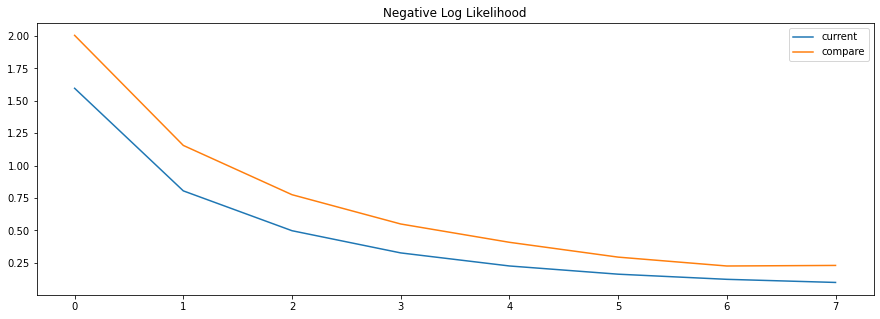

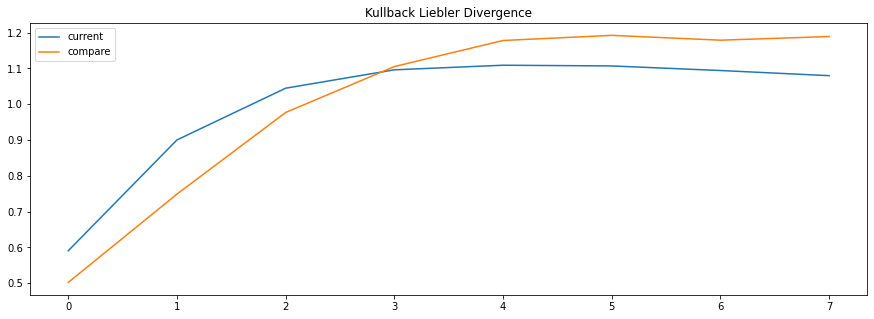

In [0]:
plt.figure(figsize=(15, 5))
plt.plot(nll_losses, label='current')
plt.plot(nll_losses_compare, label='compare')
plt.title('Negative Log Likelihood')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(kld_losses, label='current')
plt.plot(kld_losses_compare, label='compare')
plt.title('Kullback Liebler Divergence')
plt.legend()
plt.show()

### **Language Modelling**

In [0]:
sentence_0, sentence_1, interps = interpolation_evaluation(vae, test_path, n=20)

sent_0 = sentences_from_tensors(sentence_0, vocab, at=1)
sent_1 = sentences_from_tensors(sentence_1, vocab, at=1)
print(' '.join(sent_0[0]))
print(' '.join(sent_1[0]))
print('\n')

for sentence in interps:
    if READABLE: sentence = raw2readable(sentence)  
    print(' '.join(sentence))

SOS good EOS PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
SOS surprisingly sweet . clean berries . great on cereal . good packaging too . EOS


>> good <<                          
>> good <<                          
>> good <<                          
>> good <<                          
>> good <<                          
>> good <<                          
>> good <<                          
>> good << .                        
>> good spice . <<                      
>> good spice . <<   unk great   <<            
>> good spice . << << unk great   <<            
>> nice sweet . amazon << unk great . << unk << <<      
>> ok sweet . amazon << unk great and container unk price << <<    
>> ok sweet . vinegar << . great and choice unk quality ... << . <<
>> ok sweet . vinegar has . great and choice unk quality ... << . <<
>> ok sweet . clean has . great on choice unk good ... flavor . <<
>> ok sweet . clean almonds . great on pieces . good ... flavor . <<
>> refreshing swe


**Random Evaluation**

In [0]:
for sentence in random_evaluation(vae, 30, scaler=3):
    if READABLE: sentence = raw2readable(sentence)  
    print(' '.join(sentence))

>> amazing .                          
>> tastes unk mix price <<                    
>> my the favorite ice buy with <<                
>> tastes unk for low yummy in thanks delicious healthy breakfast good     <<  
>> best unk favorite bargain ! , << product <<            
>> our unk mix blend ! . <<                
>> lovely unk unk choice << can <<                
>> full unk stuff expiration buy without << product              
>> our unk of side you with <<                
>> only the unk blend ! had use                
>> tastes unk for on ?                    
>> terrific unk favorite flavored ... with                  
>> my unk of little buy with quick delicious              
>> my unk ever on buy with     <<            
>> our of new meal ! <<                  
>> tastes unk of quality ! can                  
>> tastes unk ever and !                    
>> best unk . good buy - (   <<            
>> amazing unk with smooth ! that ! product <<            
>> our unk breakfast

In [0]:
while True:
    pass

**Grammar correction**

In [0]:
sentence = 'i love this bread so much that i had to buy an infinite amount'
reconstruction = reconstruction_sample(vae, sentence, vocab)[0]
' '.join(raw2readable(reconstruction))

**Attention Evaluation**

In [0]:
sample = gather_batches(test_path, n_batches=1+1, batch_size=1)[0]
sample = batcher.insta_batch(sample, vocab)

In [0]:
vae.eval()
stats, probs, attns = vae(sample)
output = probs.max(dim=-1, keepdim=False)[1]
vae.train()

# attns: [encoder/decoder, layer, batch, head, seq X seq]
ENC_DEC = 0
LAYER = 0
HEAD = 0

for head in range(0, HEADS):
    attn = attns[ENC_DEC][LAYER][0][head].detach().cpu().numpy()
    showattn(attn, sample[0], output[0], vocab=vocab)

### **Latent Evaluation**

In [0]:
pca_codes, sent_batches = latent_evaluation(test_path, vae, n_batches=300, dims=5)

*Lenghts visualization*

In [0]:
sent_lens = [len(sent) for batch in sent_batches for sent in batch]

In [0]:
dims = range(pca_codes.shape[0])
for d1 in dims:
    for d2 in dims:
        if d1 < d2:
            plt.figure(figsize=(7.5, 7.5))
            scatter = plt.scatter(pca_codes[d1, :], pca_codes[d2, :], marker='.', c=sent_lens, s=10)
            plt.xlabel('PC_'+str(d1))
            plt.ylabel('PC_'+str(d2))
            plt.legend(handles=scatter.legend_elements()[0], labels=set(sent_lens))
            plt.show()

*Sentiment visualization*

In [0]:
SA_RNN = t.load(model_path + 'SA_RNN_' + str(25))

In [0]:
nlp = spacy.load('en')
s2i = t.load(model_path + 'S2I') 

In [0]:
sentiments = [int(predict_sentiment(SA_RNN, ' '.join(sent))*10) for batch in sent_batches for sent in batch]

In [0]:
dims = range(pca_codes.shape[0])
for d1 in dims:
    for d2 in dims:
        if d1 < d2:
            plt.figure(figsize=(7.5, 7.5))
            scatter = plt.scatter(pca_codes[d1, :], pca_codes[d2, :], marker='.', c=sentiments, s=10, cmap='copper')
            plt.xlabel('PC_'+str(d1))
            plt.ylabel('PC_'+str(d2))
            plt.legend(handles=scatter.legend_elements()[0], labels=set(sentiments))
            plt.show()

*Topic visualization* 

In [0]:
topic2id = {'coffee': 1, 'tea': 2, 'chocolate': 3, 'candy': 4, 'sugar': 5}
# topic2id = {'coffee': 1}

In [0]:
NOP = 0
topics = []
for batch in sent_batches:
    for sent in batch:
        found = False
        for key, value in topic2id.items():
            if key in sent:
                topics += [value]
                found = True
                break
        if not found:
            topics += [NOP]

In [0]:
ids2nop = {}
new_topics = []
for id, top in enumerate(topics):
    if top==NOP:
        ids2nop[id] = True
    else: 
        ids2nop[id] = False
        new_topics += [top]

In [0]:
new_codes = np.stack([pca_codes[:, k] for k, v in ids2nop.items() if not v], axis=1)

In [0]:
from matplotlib.colors import ListedColormap
my_map = ListedColormap(['green', 'red','blue', 'violet', 'pink'])
# my_map = ListedColormap(['green'])

In [0]:
dims = range(new_codes.shape[0])
for d1 in dims:
    for d2 in dims:
        if d1 < d2:
            plt.figure(figsize=(7.5, 7.5))
            scatter = plt.scatter(new_codes[d1, :], new_codes[d2, :], marker='.', c=new_topics, s=10, cmap=my_map)
            plt.xlabel('PC_'+str(d1))
            plt.ylabel('PC_'+str(d2))
            plt.legend(handles=scatter.legend_elements()[0], labels=topic2id.keys())
            plt.show()

## Novelty Detection

In [0]:
while True:
    pass

In [0]:
adv_name = 'adversarial_vae.jsonl'
# adv_name = 'adversarial_temp4.jsonl'
# adv_name = 'adversarial_k10.jsonl'

adv_path = dir_path + adv_name
adv_path

'/content/drive/My Drive/POLIMI/Thesis/Data/Datasets/Food/adversarial_vae.jsonl'

### Reconstruction Error

In [0]:
def reconstruction_error(model, ds_path, maximum=-1, vocab=vocab):
    model.eval()
    ds_size = compute_size(ds_path)
    
    sentences = []
    rec_errors = []
    with open(ds_path, 'r') as f:
        for line in f:
            sentences += [word_tokenize(json.loads(line)['review'].lower())]
            batch = batcher.insta_batch([sentences[-1]], vocab) 
            batch_size, seq_len = batch.shape
       
            _, probs, _ = model(batch)

            # Reconstruction Error
            nll_loss = NLLLoss(reduction='mean')(
                probs.reshape(batch_size * seq_len, VOCAB_SIZE), 
                batch.reshape(batch_size * seq_len))

            rec_errors += [nll_loss.item()]

            if len(rec_errors) % (ds_size//10) == 0:
                print('.', sep='', end='')

            if len(rec_errors) == maximum:
                return sentences, rec_errors
    print('!')
    return sentences, rec_errors

In [0]:
_, rec_errors = reconstruction_error(vae, dev_path)

..........!


In [0]:
rec_errors_sort = sorted(rec_errors)

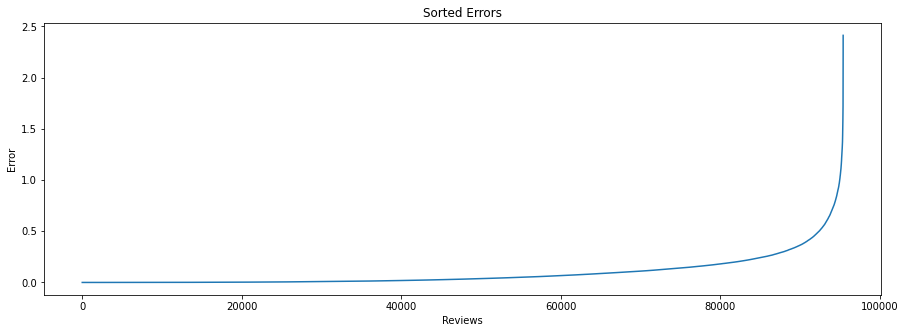

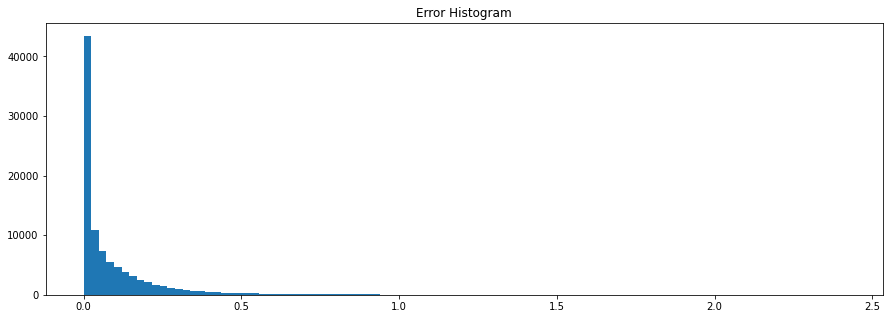

In [0]:
plt.figure(figsize=(15, 5))
plt.plot(rec_errors_sort)
plt.title('Sorted Errors')
plt.xlabel('Reviews')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(15, 5))
plt.hist(rec_errors_sort, bins=100)
plt.title('Error Histogram')
plt.show()

In [0]:
N_MOMENTS = 4

moments = []
for m in range(1, N_MOMENTS + 1):
    moments += [moment(rec_errors_sort, moment=m)]

In [0]:
print('Normalized Moments:')
moments

Normalized Moments:


[0.0, 0.025757143048892765, 0.014891213818004356, 0.014471089819933365]

**Cutting the right tail**

In [0]:
keep_perc = 0.90

In [0]:
rec_error_cut = rec_errors_sort[:int(len(rec_errors_sort)*keep_perc)]

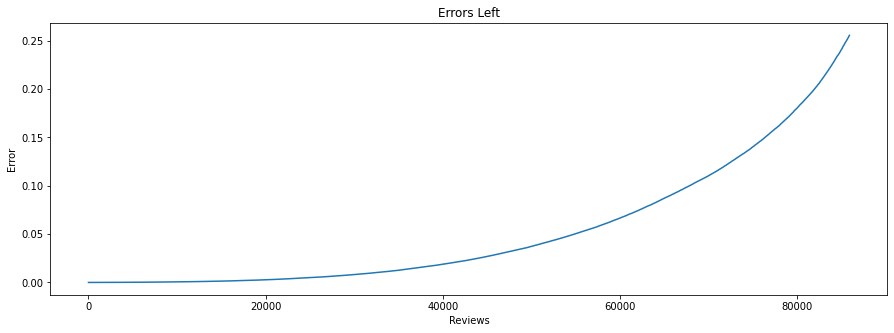

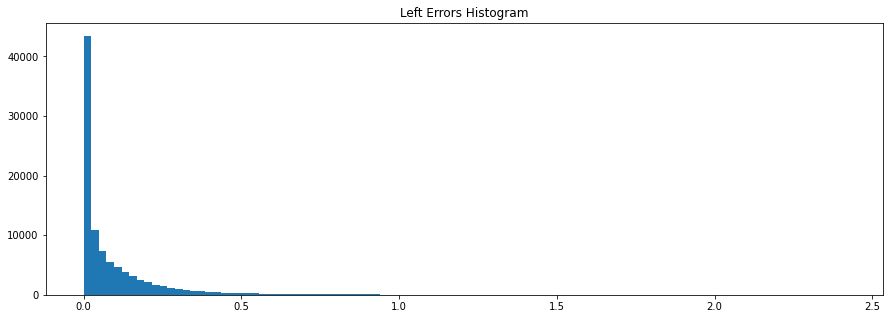

In [0]:
plt.figure(figsize=(15, 5))
plt.plot(rec_error_cut)
plt.title('Errors Left')
plt.xlabel('Reviews')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(15, 5))
plt.hist(rec_errors_sort, bins=100)
plt.title('Left Errors Histogram')
plt.show()

In [0]:
thr = max(rec_error_cut)
thr

0.25570249557495117

**Generating the adversarial dataset**

In [0]:
ADV_DS_SIZE = 4096
ADV_SCALER = 4

In [0]:
GENERATE_IT = False

In [0]:
if GENERATE_IT = False:
    adv_dataset = set()
    for sentence in random_evaluation(vae, ADV_DS_SIZE, scaler=ADV_SCALER):
        adv_dataset.add(' '.join(raw2adversarial(sentence))[1:])
    adv_dataset = sorted(list(adv_dataset))
    adv_ds_size = len(adv_dataset)

In [0]:
if GENERATE_IT:
    with open(adv_path, 'w') as f:
        i = 0
        for r in tqdm(adv_dataset):
            json.dump({'id': i, 'review': r}, f)
            f.write('\n')
            i += 1

In [0]:
if GENERATE_IT:
    import random

    how_many = 10
    start = int(random.random()*adv_ds_size)

    adv_dataset[start:start+how_many]

**Adversarial Defense** using reconstruction.

Computing the error and predicting

In [0]:
adv_sents, adv_errors = reconstruction_error(vae, adv_path, vocab)
test_sents, test_errors = reconstruction_error(vae, test_path, maximum=len(adv_errors), vocab=vocab)
pred_sents = adv_sents + test_sents
errors = adv_errors + test_errors

..........!


In [0]:
len(adv_errors), len(test_errors)

(1292, 1292)

In [0]:
preds = [1 if err > thr else 0 for err in errors]
targs = [1] * len(adv_errors) + [0] * len(test_errors)

Performance evaluation 

In [0]:
accuracy = balanced_accuracy_score(targs, preds)
precision = average_precision_score(targs, preds)
recall = recall_score(targs, preds)
f1 = f1_score(targs, preds)

In [0]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1:', f1)

accuracy: 0.5309597523219814
precision: 0.5163280885533738
recall: 0.5959752321981424
f1: 0.559593023255814


Visualization

In [0]:
fix(vae, requires_grad=False)

bs = 64
batch = []
pred_batches = []
for s in pred_sents:
    batch += [s]
    if len(batch) == bs:
        pred_batches += [batcher.insta_batch(batch, vocab)]
        batch = []

pred_codes = []
for batch in pred_batches:
    mu_batch, logvar_batch, _ = vae.encoder(batch)
    pred_codes += [vae.distribute(mu_batch, logvar_batch)]
pred_codes = t.cat(pred_codes, dim=0).cpu().numpy()
pred_codes.shape

In [0]:
rec_components = 4
rec_pca = PCA(n_components=rec_components)
rec_pca.fit(pred_codes)

In [0]:
rec_map = ListedColormap(['blue','red'])

In [0]:
for d1 in range(rec_components):
    for d2 in range(rec_components):
        if d1 < d2:
            pca_codes = rec_pca.transform(pred_codes).T

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))
            ax1.scatter(pca_codes[d1, :], 
                        pca_codes[d2, :], 
                        marker='.', c=targs, s=20, cmap=def_map)
            ax1.set_title('Ground truth')
            ax1.set(xlabel='PC_'+str(d1), ylabel='PC_'+str(d2))

            ax2.scatter(pca_codes[d1, :], 
                        pca_codes[d2, :], 
                        marker='.', c=preds, s=20, cmap=def_map)
            ax2.set_title('Predictions')
            ax2.set(xlabel='PC_'+str(d1), ylabel='PC_'+str(d2))
            plt.show()

### Gaussian Mixture Model

Dataset Generation

In [0]:
fix(vae, requires_grad=False)

In [0]:
sent_batches = gather_batches(train_path, n_batches=300)
print(len(sent_batches))
batches = [batcher.insta_batch(batch, vocab) for batch in sent_batches]

X_train = []
for batch in batches:
    mu_batch, logvar_batch, _ = vae.encoder(batch)
    X_train += [vae.distribute(mu_batch, logvar_batch)]

X_train = t.cat(X_train, dim=0).cpu().numpy()
X_train.shape

In [0]:
components = 3
pca = PCA(n_components=components)
pca.fit(X_train)

In [0]:
X_train = pca.transform(X_train)

In [0]:
sent_batches = gather_batches(dev_path, n_batches=300)
print(len(sent_batches))
batches = [batcher.insta_batch(batch, vocab) for batch in sent_batches]

X_dev = []
for batch in batches:
    mu_batch, logvar_batch, _ = vae.encoder(batch)
    X_dev += [vae.distribute(mu_batch, logvar_batch)]

X_dev = t.cat(X_dev, dim=0).cpu().numpy()
X_dev.shape

In [0]:
X_dev = pca.transform(X_dev)

In [0]:
sent_batches = gather_batches(test_path, n_batches=4)
print(len(sent_batches))
batches = [batcher.insta_batch(batch, vocab) for batch in sent_batches]

X_test = []
for batch in batches:
    mu_batch, logvar_batch, _ = vae.encoder(batch)
    X_test += [vae.distribute(mu_batch, logvar_batch)]

X_test = t.cat(X_test, dim=0).cpu().numpy()
X_test.shape

In [0]:
X_test = pca.transform(X_test)

In [0]:
sent_batches = gather_batches(adv_path, n_batches=4)
print(len(sent_batches))
batches = [batcher.insta_batch(batch, vocab) for batch in sent_batches]

X_adv = []
for batch in batches:
    mu_batch, logvar_batch, _ = vae.encoder(batch)
    X_adv += [vae.distribute(mu_batch, logvar_batch)]

X_adv = t.cat(X_adv, dim=0).cpu().numpy()
X_adv.shape

In [0]:
X_adv = pca.transform(X_adv)

In [0]:
X_pred = np.vstack([X_test, X_adv])
targs = [0] * X_test.shape[0] + [1] * X_adv.shape[0]

Gaussian Mixture Model

In [0]:
from sklearn.mixture import GaussianMixture

In [0]:
gmm = GaussianMixture(n_components=10, covariance_type='full', 
                      tol=0.001, reg_covar=1e-06, max_iter=100, 
                      n_init=1, init_params='kmeans', random_state=69420, 
                      warm_start=True, verbose=2, verbose_interval=10)

In [0]:
gmm.fit(X_dev)

In [0]:
probs = gmm.predict_proba(X_pred).max(axis=-1)

In [0]:
thr = 0.65

In [0]:
preds = [1 if p < thr else 0 for p in probs]

Performances

In [0]:
accuracy = balanced_accuracy_score(targs, preds)
precision = average_precision_score(targs, preds)
recall = recall_score(targs, preds)
f1 = f1_score(targs, preds)

In [0]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1:', f1)

Visualization

In [0]:
for d1 in range(components):
    for d2 in range(components):
        if d1 < d2:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))
            ax1.scatter(X_pred[:, d1], 
                        X_pred[:, d2], 
                        marker='.', c=targs, s=20, cmap=ListedColormap(['blue','red']))
            ax1.set_title('Ground truth')
            ax1.set(xlabel='PC_'+str(d1), ylabel='PC_'+str(d2))

            ax2.scatter(X_pred[:, d1], 
                        X_pred[:, d2], 
                        marker='.', c=preds, s=20, cmap=ListedColormap(['blue','red']))
            ax2.set_title('Predictions')
            ax2.set(xlabel='PC_'+str(d1), ylabel='PC_'+str(d2))
            plt.show()

In [0]:
for d1 in range(components):
    for d2 in range(components):
        if d1 < d2:
            pca_codes = pca.transform(X_pred).T

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))
            ax1.scatter(pca_codes[d1, :], 
                        pca_codes[d2, :], 
                        marker='.', c=targs, s=20, cmap=ListedColormap(['blue','red']))
            ax1.set_title('Ground truth')
            ax1.set(xlabel='PC_'+str(d1), ylabel='PC_'+str(d2))

            ax2.scatter(pca_codes[d1, :], 
                        pca_codes[d2, :], 
                        marker='.', c=preds, s=20, cmap=ListedColormap(['blue','red']))
            ax2.set_title('Predictions')
            ax2.set(xlabel='PC_'+str(d1), ylabel='PC_'+str(d2))
            plt.show()

### DBSCAN

In [0]:
fix(vae, requires_grad=False)

In [0]:
sent_batches = gather_batches(test_path, n_batches=5)
sent_batches = sent_batches[:4]
print(len(sent_batches))
batches = [batcher.insta_batch(batch, vocab) for batch in sent_batches]

X_test = []
for batch in batches:
    mu_batch, logvar_batch, _ = vae.encoder(batch)
    X_test += [vae.distribute(mu_batch, logvar_batch)]

X_test = t.cat(X_test, dim=0).cpu().numpy()
X_test.shape

In [0]:
sent_batches = gather_batches(adv_path, n_batches=4)
print(len(sent_batches))
batches = [batcher.insta_batch(batch, vocab) for batch in sent_batches]

X_adv = []
for batch in batches:
    mu_batch, logvar_batch, _ = vae.encoder(batch)
    X_adv += [vae.distribute(mu_batch, logvar_batch)]

X_adv = t.cat(X_adv, dim=0).cpu().numpy()
X_adv.shape

In [0]:
X_pred = np.vstack([X_test, X_adv])
targs = [0] * X_test.shape[0] + [1] * X_adv.shape[0]

DBSCAN Clustering

In [0]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=8, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)

In [0]:
preds = dbscan.fit_predict(X_test)
set(preds)

In [0]:
preds = dbscan.fit_predict(X_pred)
set(preds)

In [0]:
preds = [0 if p == -1 else 1 for p in preds]

Performances

In [0]:
accuracy = balanced_accuracy_score(targs, preds)
precision = average_precision_score(targs, preds)
recall = recall_score(targs, preds)
f1 = f1_score(targs, preds)

In [0]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1:', f1)

Visualization

In [0]:
components = 3
pca = PCA(n_components=components)
pca.fit(X_pred)

In [0]:
for d1 in range(components):
    for d2 in range(components):
        if d1 < d2:
            pca_codes = pca.transform(X_pred).T

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))
            ax1.scatter(pca_codes[d1, :], 
                        pca_codes[d2, :], 
                        marker='.', c=targs, s=20, cmap=ListedColormap(['blue','red']))
            ax1.set_title('Ground truth: ' + adv_name)
            ax1.set(xlabel='PC_'+str(d1), ylabel='PC_'+str(d2))

            ax2.scatter(pca_codes[d1, :], 
                        pca_codes[d2, :], 
                        marker='.', c=preds, s=20, cmap=ListedColormap(['blue','red']))
            ax2.set_title('Predictions: ' + adv_name)
            ax2.set(xlabel='PC_'+str(d1), ylabel='PC_'+str(d2))
            plt.show()

### One-class SVM

X_train generation.

In [0]:
fix(vae, requires_grad=False)

train_batches = gather_batches(adv_path, 300)

train_batches = [batcher.insta_batch(batch, vocab) for batch in train_batches]

train_codes = []
for batch in train_batches:
    mu_batch, logvar_batch, _ = vae.encoder(batch)
    train_codes += [vae.distribute(mu_batch, logvar_batch)]
train_codes = t.cat(train_codes, dim=0).cpu().numpy()

X_test generation.

In [0]:
fix(vae, requires_grad=False)

adv_batches = gather_batches(adv_path, 300)
true_batches = gather_batches(test_path, 300)

adv_batches = [batcher.insta_batch(batch, vocab) for batch in adv_batches]
true_batches = [batcher.insta_batch(batch, vocab) for batch in true_batches]

adv_codes = []
for batch in adv_batches:
    mu_batch, logvar_batch, _ = vae.encoder(batch)
    adv_codes += [vae.distribute(mu_batch, logvar_batch)]
adv_codes = t.cat(adv_codes, dim=0).cpu().numpy()

true_codes = []
for batch in true_batches:
    mu_batch, logvar_batch, _ = vae.encoder(batch)
    true_codes += [vae.distribute(mu_batch, logvar_batch)]
true_codes = t.cat(true_codes, dim=0).cpu().numpy()[:adv_codes.shape[0], :]

In [0]:
adv_codes.shape, true_codes.shape

In [0]:
test_set = np.vstack([adv_codes, true_codes])
test_labels = np.array([-1]*adv_codes.shape[0]+[1]*true_codes.shape[0])

In [0]:
def_components = 4
def_pca = PCA(n_components=def_components)
def_pca.fit(train_codes)

OC-SVM

In [0]:
from sklearn.svm import OneClassSVM
svm = OneClassSVM(kernel='rbf', coef0=10, gamma='scale', tol=0.0001, max_iter=-1)

In [0]:
svm.fit(train_codes)

In [0]:
predictions = svm.predict(test_set)

In [0]:
accuracy = balanced_accuracy_score(test_labels, predictions)
precision = average_precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

In [0]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1:', f1)

Visualization

In [0]:
import seaborn as sns; sns.set()

In [0]:
def_map = ListedColormap(['blue','red'])

In [0]:
for d1 in range(def_components):
    for d2 in range(def_components):
        if d1 < d2:
            pca_codes = def_pca.transform(test_set).T

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))
            ax1.scatter(pca_codes[d1, :], 
                        pca_codes[d2, :], 
                        marker='.', c=targs, s=20, cmap=def_map)
            ax1.set_title('Ground truth')
            ax1.set(xlabel='PC_'+str(d1), ylabel='PC_'+str(d2))

            ax2.scatter(pca_codes[d1, :], 
                        pca_codes[d2, :], 
                        marker='.', c=preds, s=20, cmap=def_map)
            ax2.set_title('Predictions')
            ax2.set(xlabel='PC_'+str(d1), ylabel='PC_'+str(d2))
            plt.show()

In [0]:
for d1 in range(def_components):
    for d2 in range(def_components):
        if d1 < d2:
            pca_codes = def_pca.transform(test_set).T

            plt.figure(figsize=(7.5, 7.5))
            plt.scatter(pca_codes[d1, :], 
                        pca_codes[d2, :], 
                        marker='.', c=test_labels, s=20, cmap=def_map)
            plt.title('Ground truth')
            plt.xlabel('PC_'+str(d1)) 
            plt.ylabel('PC_'+str(d2))
            plt.show()

In [0]:
adv_reviews = []
with open(adv_path, 'r') as f:
    for line in f:
        adv_reviews += [json.loads(line)['review']]

In [0]:
import random

how_many = 10
start = int(random.random()*len(adv_reviews))

adv_reviews[start:start+how_many]

# TODO:
- PAY ATTENTION: SWITCH fix(model) WITH torch.no_grad()
- Add residual connections on half and half of both decoder and encoder.
- Try out bach norm instead of layer norm.